# Dense vs Sparse Attention - Comprehensive Comparison

**Memory-Optimized Training with Gradient Accumulation**

This notebook compares:
1. Dense attention
2. Sparse attention (local pattern - best speedup/accuracy trade-off)

With seq_len=512, batch_size=8, gradient_accumulation=4 (effective batch=32)

## Setup

In [1]:
import os
import sys
import time
import gc
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Set project path - ADJUST THIS TO YOUR PATH
project_path = '/workspace/manav/dl_sys_project/'
os.chdir(project_path)

# Check GPU
print("Checking GPU availability...")
try:
    import subprocess
    gpu_info = subprocess.check_output(['nvidia-smi'], stderr=subprocess.STDOUT)
    print("✓ GPU Available")
except:
    print("✗ No GPU detected - will use CPU")

# Rebuild project
print("\nRebuilding project...")
# !make clean
!make

# Setup paths
sys.path.insert(0, os.path.join(project_path, 'python'))
sys.path.insert(0, os.path.join(project_path, 'apps'))


# Imports
import needle as ndl
import needle.nn as nn
from pythia_model import PythiaConfig, PythiaLM
from train_pythia_optimized import (
    load_dataset_huggingface,
    train_epoch_with_accumulation,
    evaluate,
    save_checkpoint
)

print("✓ Imports successful")
print(f"Needle backend: {ndl.backend_selection.BACKEND}")
# Set device
try:
    device = ndl.cuda()
    print("✓ Using CUDA (GPU)")
except Exception as e:
    print(f"✗ CUDA not available: {e}")
    device = ndl.cpu()
    print("Using CPU instead")

np.random.seed(42)


Checking GPU availability...
✓ GPU Available

Rebuilding project...
-- Found pybind11: /usr/local/lib/python3.12/dist-packages/pybind11/include (found version "3.0.1")
-- Found cuda, building cuda backend
Mon Nov 24 19:48:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:0F:00.0 Off |                    0 |
| N/A   33C    P0          

## Configuration

In [2]:
# Training config - optimized for 80GB GPU
EPOCHS = 5 
BATCH_SIZE = 4  # Physical batch size
ACCUMULATION_STEPS = 8  # Effective batch = 32
SEQ_LEN = 128  # Long sequences to showcase sparse benefits
LEARNING_RATE = 3e-4
VOCAB_SIZE = 10000
MAX_TOKENS = 500000

print("="*80)
print("CONFIGURATION")
print("="*80)
print(f"Epochs: {EPOCHS}")
print(f"Physical batch size: {BATCH_SIZE}")
print(f"Gradient accumulation: {ACCUMULATION_STEPS}")
print(f"Effective batch size: {BATCH_SIZE * ACCUMULATION_STEPS}")
print(f"Sequence length: {SEQ_LEN}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Device: {device}")
print("="*80)

CONFIGURATION
Epochs: 5
Physical batch size: 4
Gradient accumulation: 8
Effective batch size: 32
Sequence length: 128
Learning rate: 0.0003
Vocabulary size: 10000
Device: cuda()


## Load Dataset

In [3]:
print("Loading dataset...")
try:
    train_data, val_data, vocab_size = load_dataset_huggingface(
        "wikitext-2", 
        max_tokens=MAX_TOKENS,
        vocab_size=VOCAB_SIZE
    )
    dataset_name = "WikiText-2"
except Exception as e:
    print(f"Error loading WikiText-2: {e}")
    print("Using synthetic data")
    from train_pythia_optimized import load_synthetic_data
    train_data, val_data, vocab_size = load_synthetic_data(MAX_TOKENS, VOCAB_SIZE)
    dataset_name = "Synthetic"

print(f"\n{'='*80}")
print("DATASET SUMMARY")
print(f"{'='*80}")
print(f"Dataset: {dataset_name}")
print(f"Vocabulary: {vocab_size:,} tokens")
print(f"Train: {len(train_data):,} tokens")
print(f"Validation: {len(val_data):,} tokens")
print(f"{'='*80}")

Loading dataset...
Loading wikitext-2...
Vocabulary size: 10000
Train tokens: 500000, Val tokens: 50000

DATASET SUMMARY
Dataset: WikiText-2
Vocabulary: 10,000 tokens
Train: 500,000 tokens
Validation: 50,000 tokens


## Train Dense Model

In [4]:
gc.collect()
print("✓ Memory cleared before dense training")

# Memory Monitoring
def print_memory_usage():
    try:
        import torch
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        print(f"GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")
        return allocated, reserved
    except:
        print("GPU memory monitoring not available")
        return 0, 0

print("Initial memory:")
print_memory_usage()

✓ Memory cleared before dense training
Initial memory:
GPU Memory: 0.00GB allocated, 0.00GB reserved


(0.0, 0.0)

In [5]:
print("\n" + "="*80)
print("TRAINING DENSE ATTENTION MODEL")
print("="*80)

# Clear CUDA cache before starting
try:
    import torch
    torch.cuda.empty_cache()
except:
    pass
gc.collect()

# Create config
config_dense = PythiaConfig(
    vocab_size=vocab_size,
    d_model=512,
    num_heads=8,
    num_layers=6,
    d_ff=2048,
    max_seq_len=SEQ_LEN,
    dropout=0.1,
    device=device,
    dtype="float32",
    use_sparse_attention=False
)

model_dense = PythiaLM(config_dense)
print(f"Model: {config_dense.get_total_params() / 1e6:.1f}M parameters")

# Optimizer
optimizer_dense = ndl.optim.Adam(model_dense.parameters(), lr=LEARNING_RATE, weight_decay=0.0)
train_losses_dense = []
val_losses_dense = []
perplexities_dense = []

start_time_dense = time.time()

for epoch in range(EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*80}")
    
    # Train with EXPLICIT cleanup
    model_dense.train()
    epoch_loss = 0.0
    epoch_tokens = 0
    batch_count = 0
    epoch_start_time = time.time()
    
    from train_pythia_optimized import batchify_streaming, get_batch
    
    for batch_data in batchify_streaming(train_data, BATCH_SIZE, SEQ_LEN):
        step_start_time = time.time()
        
        inputs, targets = get_batch(batch_data, device)
        
        # Forward
        logits, loss = model_dense(inputs, targets)
        loss_scaled = loss / ACCUMULATION_STEPS
        
        # Backward
        loss_scaled.backward()
        
        # Track
        loss_val = loss.numpy()
        if isinstance(loss_val, np.ndarray):
            loss_val = loss_val.item()
        epoch_loss += loss_val * BATCH_SIZE * SEQ_LEN
        epoch_tokens += BATCH_SIZE * SEQ_LEN
        batch_count += 1
        
        # CRITICAL: Delete tensors immediately
        del inputs, targets, logits, loss, loss_scaled
        
        # Update weights
        if batch_count % ACCUMULATION_STEPS == 0:
            optimizer_dense.step()
            optimizer_dense.reset_grad()
            
            # Calculate tokens/sec for this update step
            step_time = time.time() - step_start_time
            step_tokens = BATCH_SIZE * SEQ_LEN * ACCUMULATION_STEPS
            tokens_per_sec = step_tokens / step_time if step_time > 0 else 0
            
            # Print progress every 10 updates
            if (batch_count // ACCUMULATION_STEPS) % 10 == 0:
                current_loss = epoch_loss / epoch_tokens if epoch_tokens > 0 else 0
                print(f"  Step {batch_count:4d} | Loss: {current_loss:.4f} | {tokens_per_sec:.0f} tokens/sec")
            
            # Aggressive cleanup every update
            if (batch_count // ACCUMULATION_STEPS) % 5 == 0:
                gc.collect()
                try:
                    import torch
                    torch.cuda.empty_cache()
                except:
                    pass
        
        # Break after reasonable number of batches for testing
        if batch_count >= 100:  # Adjust as needed
            break
    
    # Final update
    if batch_count % ACCUMULATION_STEPS != 0:
        optimizer_dense.step()
        optimizer_dense.reset_grad()
    
    # Calculate epoch metrics
    train_loss = epoch_loss / epoch_tokens if epoch_tokens > 0 else 0
    train_losses_dense.append(train_loss)
    
    epoch_time = time.time() - epoch_start_time
    epoch_tokens_per_sec = epoch_tokens / epoch_time if epoch_time > 0 else 0
    
    # Evaluate
    model_dense.eval()
    val_loss, val_ppl = evaluate(model_dense, val_data, BATCH_SIZE, SEQ_LEN, device, max_batches=50)
    val_losses_dense.append(val_loss)
    perplexities_dense.append(val_ppl)
    
    print(f"\nTrain Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | PPL: {val_ppl:.2f} | {epoch_tokens_per_sec:.0f} tokens/sec")
    
    # Cleanup after each epoch
    gc.collect()
    try:
        import torch
        torch.cuda.empty_cache()
    except:
        pass

train_time_dense = time.time() - start_time_dense

print(f"\n{'='*80}")
print("DENSE MODEL COMPLETE")
print(f"Time: {train_time_dense/60:.2f} min")
print(f"Final Loss: {val_losses_dense[-1]:.4f}")
print(f"Final PPL: {perplexities_dense[-1]:.2f}")
print(f"{'='*80}")

# IMMEDIATE CLEANUP after training
print("\n🧹 Cleaning up dense model memory...")
del optimizer_dense
gc.collect()
try:
    import torch
    torch.cuda.empty_cache()
    print("✓ CUDA cache cleared")
except:
    pass

# Clear gradients
for param in model_dense.parameters():
    param.grad = None

print("✓ Dense model cleanup complete\n")


TRAINING DENSE ATTENTION MODEL
Model: 24.1M parameters

Epoch 1/5
  Step   80 | Loss: 8.7449 | 3510 tokens/sec

Train Loss: 8.5279 | Val Loss: 7.1133 | PPL: 1228.15 | 447 tokens/sec

Epoch 2/5
  Step   80 | Loss: 6.9894 | 2866 tokens/sec

Train Loss: 6.9656 | Val Loss: 6.7572 | PPL: 860.26 | 453 tokens/sec

Epoch 3/5
  Step   80 | Loss: 6.7108 | 3534 tokens/sec

Train Loss: 6.7195 | Val Loss: 6.7464 | PPL: 851.02 | 442 tokens/sec

Epoch 4/5
  Step   80 | Loss: 6.6901 | 3479 tokens/sec

Train Loss: 6.7046 | Val Loss: 6.8621 | PPL: 955.35 | 447 tokens/sec

Epoch 5/5
  Step   80 | Loss: 6.7305 | 3500 tokens/sec

Train Loss: 6.7422 | Val Loss: 6.9327 | PPL: 1025.26 | 448 tokens/sec

DENSE MODEL COMPLETE
Time: 11.07 min
Final Loss: 6.9327
Final PPL: 1025.26

🧹 Cleaning up dense model memory...
✓ CUDA cache cleared
✓ Dense model cleanup complete



## Train Sparse Model (Local Pattern - Best Performance)

In [6]:
print("\n" + "="*80)
print("TRAINING SPARSE ATTENTION MODEL (LOCAL PATTERN)")
print("="*80)

# Clear CUDA cache before starting
try:
    import torch
    torch.cuda.empty_cache()
except:
    pass
gc.collect()

# Create config
config_sparse = PythiaConfig(
    vocab_size=vocab_size,
    d_model=512,
    num_heads=8,
    num_layers=6,
    d_ff=2048,
    max_seq_len=SEQ_LEN,
    dropout=0.1,
    device=device,
    dtype="float32",
    use_sparse_attention=True,  # SPARSE
    sparse_block_size=64,
    sparse_pattern="local"  # Best speedup/accuracy
)

model_sparse = PythiaLM(config_sparse)
print(f"Model: {config_sparse.get_total_params() / 1e6:.1f}M parameters")
print(f"Pattern: local (sliding window)")
print(f"Block size: 64")
print(f"Sparsity: ~75%")

# Optimizer
optimizer_sparse = ndl.optim.Adam(model_sparse.parameters(), lr=LEARNING_RATE, weight_decay=0.0)
train_losses_sparse = []
val_losses_sparse = []
perplexities_sparse = []

start_time_sparse = time.time()

for epoch in range(EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*80}")
    
    # Train with EXPLICIT cleanup
    model_sparse.train()
    epoch_loss = 0.0
    epoch_tokens = 0
    batch_count = 0
    epoch_start_time = time.time()
    
    from train_pythia_optimized import batchify_streaming, get_batch
    
    for batch_data in batchify_streaming(train_data, BATCH_SIZE, SEQ_LEN):
        step_start_time = time.time()
        
        inputs, targets = get_batch(batch_data, device)
        
        # Forward
        logits, loss = model_sparse(inputs, targets)
        loss_scaled = loss / ACCUMULATION_STEPS
        
        # Backward
        loss_scaled.backward()
        
        # Track
        loss_val = loss.numpy()
        if isinstance(loss_val, np.ndarray):
            loss_val = loss_val.item()
        epoch_loss += loss_val * BATCH_SIZE * SEQ_LEN
        epoch_tokens += BATCH_SIZE * SEQ_LEN
        batch_count += 1
        
        # CRITICAL: Delete tensors immediately
        del inputs, targets, logits, loss, loss_scaled
        
        # Update weights
        if batch_count % ACCUMULATION_STEPS == 0:
            optimizer_sparse.step()
            optimizer_sparse.reset_grad()
            
            # Calculate tokens/sec for this update step
            step_time = time.time() - step_start_time
            step_tokens = BATCH_SIZE * SEQ_LEN * ACCUMULATION_STEPS
            tokens_per_sec = step_tokens / step_time if step_time > 0 else 0
            
            # Print progress every 10 updates
            if (batch_count // ACCUMULATION_STEPS) % 10 == 0:
                current_loss = epoch_loss / epoch_tokens if epoch_tokens > 0 else 0
                print(f"  Step {batch_count:4d} | Loss: {current_loss:.4f} | {tokens_per_sec:.0f} tokens/sec")
            
            # Aggressive cleanup every update
            if (batch_count // ACCUMULATION_STEPS) % 5 == 0:
                gc.collect()
                try:
                    import torch
                    torch.cuda.empty_cache()
                except:
                    pass
        
        # Break after reasonable number of batches for testing
        if batch_count >= 100:  # Adjust as needed
            break
    
    # Final update
    if batch_count % ACCUMULATION_STEPS != 0:
        optimizer_sparse.step()
        optimizer_sparse.reset_grad()
    
    # Calculate epoch metrics
    train_loss = epoch_loss / epoch_tokens if epoch_tokens > 0 else 0
    train_losses_sparse.append(train_loss)
    
    epoch_time = time.time() - epoch_start_time
    epoch_tokens_per_sec = epoch_tokens / epoch_time if epoch_time > 0 else 0
    
    # Evaluate
    model_sparse.eval()
    val_loss, val_ppl = evaluate(model_sparse, val_data, BATCH_SIZE, SEQ_LEN, device, max_batches=50)
    val_losses_sparse.append(val_loss)
    perplexities_sparse.append(val_ppl)
    
    print(f"\nTrain Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | PPL: {val_ppl:.2f} | {epoch_tokens_per_sec:.0f} tokens/sec")
    
    # Cleanup after each epoch
    gc.collect()
    try:
        import torch
        torch.cuda.empty_cache()
    except:
        pass

train_time_sparse = time.time() - start_time_sparse

print(f"\n{'='*80}")
print("SPARSE MODEL COMPLETE")
print(f"Time: {train_time_sparse/60:.2f} min")
print(f"Final Loss: {val_losses_sparse[-1]:.4f}")
print(f"Final PPL: {perplexities_sparse[-1]:.2f}")
print(f"{'='*80}")

# IMMEDIATE CLEANUP after training
print("\n🧹 Cleaning up sparse model memory...")
del optimizer_sparse
gc.collect()
try:
    import torch
    torch.cuda.empty_cache()
    print("✓ CUDA cache cleared")
except:
    pass

# Clear gradients
for param in model_sparse.parameters():
    param.grad = None

print("✓ Sparse model cleanup complete\n")


TRAINING SPARSE ATTENTION MODEL (LOCAL PATTERN)
Model: 24.1M parameters
Pattern: local (sliding window)
Block size: 64
Sparsity: ~75%

Epoch 1/5
  Step   80 | Loss: 8.4365 | 4546 tokens/sec

Train Loss: 8.2437 | Val Loss: 7.0131 | PPL: 1111.09 | 555 tokens/sec

Epoch 2/5
  Step   80 | Loss: 6.9372 | 4572 tokens/sec

Train Loss: 6.9304 | Val Loss: 6.7343 | PPL: 840.79 | 553 tokens/sec

Epoch 3/5
  Step   80 | Loss: 6.6769 | 4512 tokens/sec

Train Loss: 6.6979 | Val Loss: 6.7744 | PPL: 875.17 | 557 tokens/sec

Epoch 4/5
  Step   80 | Loss: 6.6740 | 4560 tokens/sec

Train Loss: 6.6973 | Val Loss: 6.8534 | PPL: 947.14 | 557 tokens/sec

Epoch 5/5
  Step   80 | Loss: 6.7206 | 4561 tokens/sec

Train Loss: 6.7402 | Val Loss: 6.9340 | PPL: 1026.57 | 560 tokens/sec

SPARSE MODEL COMPLETE
Time: 8.71 min
Final Loss: 6.9340
Final PPL: 1026.57

🧹 Cleaning up sparse model memory...
✓ CUDA cache cleared
✓ Sparse model cleanup complete



## Training Time Comparison


TRAINING TIME COMPARISON

Dense:  11.07 min (132.8s/epoch)
Sparse: 8.71 min (104.5s/epoch)

SPEEDUP: 1.27×
Time saved: 2.36 minutes


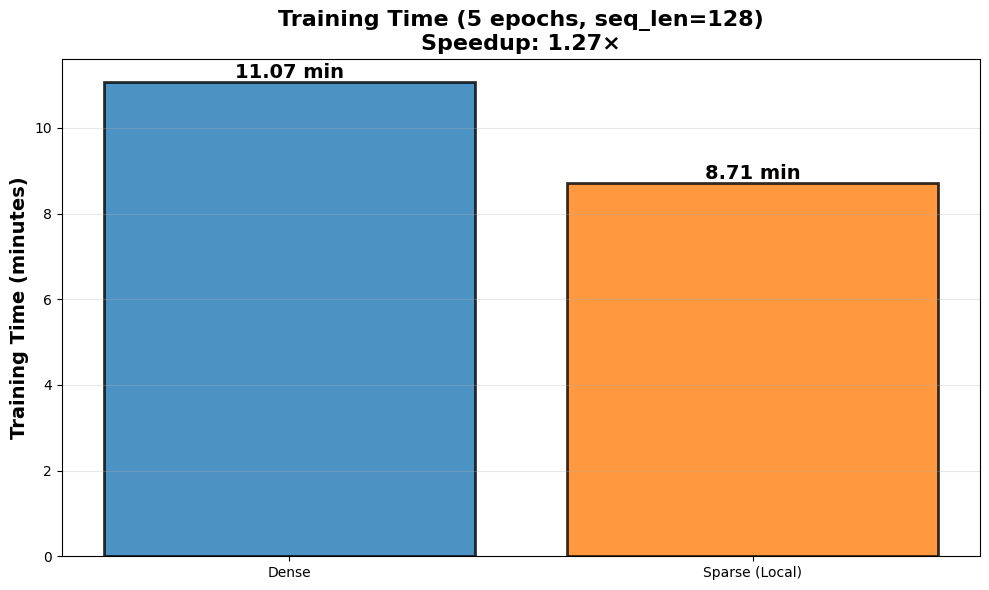

In [8]:
training_speedup = train_time_dense / train_time_sparse

print("\n" + "="*80)
print("TRAINING TIME COMPARISON")
print("="*80)
print(f"\nDense:  {train_time_dense/60:.2f} min ({train_time_dense/EPOCHS:.1f}s/epoch)")
print(f"Sparse: {train_time_sparse/60:.2f} min ({train_time_sparse/EPOCHS:.1f}s/epoch)")
print(f"\n{'='*80}")
print(f"SPEEDUP: {training_speedup:.2f}×")
print(f"Time saved: {(train_time_dense - train_time_sparse)/60:.2f} minutes")
print("="*80)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
models = ['Dense', 'Sparse (Local)']
times = [train_time_dense/60, train_time_sparse/60]
colors = ['#1f77b4', '#ff7f0e']

bars = ax.bar(models, times, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{time_val:.2f} min',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Training Time (minutes)', fontsize=14, fontweight='bold')
ax.set_title(f'Training Time ({EPOCHS} epochs, seq_len={SEQ_LEN})\nSpeedup: {training_speedup:.2f}×', 
             fontsize=16, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/training_time.png', dpi=150, bbox_inches='tight')
plt.show()

## Loss and Perplexity Comparison

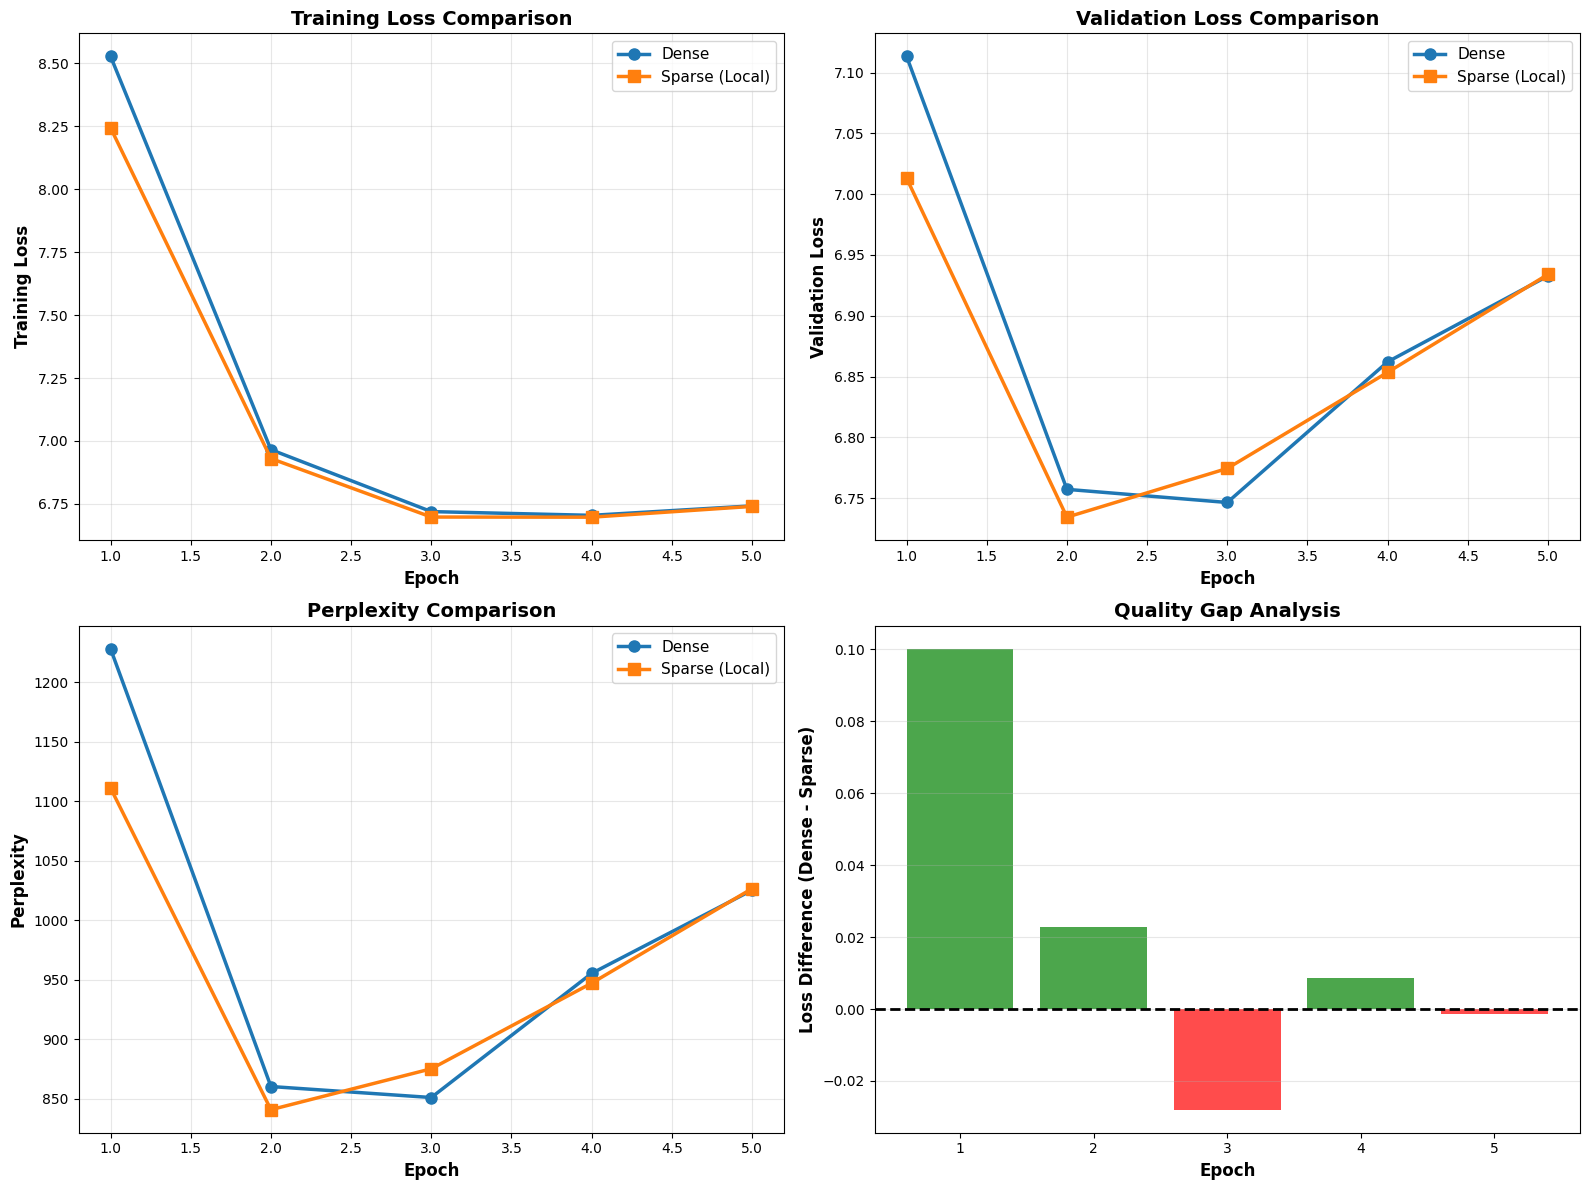


LOSS & PERPLEXITY SUMMARY

Final Training Loss:
  Dense:  6.7422
  Sparse: 6.7402
  Δ: 0.0020

Final Validation Loss:
  Dense:  6.9327
  Sparse: 6.9340
  Δ: 0.0013

Final Perplexity:
  Dense:  1025.26
  Sparse: 1026.57
  Δ: 1.31


In [9]:
epochs = range(1, EPOCHS + 1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Training loss
ax1.plot(epochs, train_losses_dense, 'o-', label='Dense', linewidth=2.5, markersize=8, color='#1f77b4')
ax1.plot(epochs, train_losses_sparse, 's-', label='Sparse (Local)', linewidth=2.5, markersize=8, color='#ff7f0e')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Training Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Validation loss
ax2.plot(epochs, val_losses_dense, 'o-', label='Dense', linewidth=2.5, markersize=8, color='#1f77b4')
ax2.plot(epochs, val_losses_sparse, 's-', label='Sparse (Local)', linewidth=2.5, markersize=8, color='#ff7f0e')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
ax2.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# 3. Perplexity
ax3.plot(epochs, perplexities_dense, 'o-', label='Dense', linewidth=2.5, markersize=8, color='#1f77b4')
ax3.plot(epochs, perplexities_sparse, 's-', label='Sparse (Local)', linewidth=2.5, markersize=8, color='#ff7f0e')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Perplexity', fontsize=12, fontweight='bold')
ax3.set_title('Perplexity Comparison', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# 4. Loss gap analysis
val_diff = [d - s for d, s in zip(val_losses_dense, val_losses_sparse)]
colors = ['green' if x >= 0 else 'red' for x in val_diff]
ax4.bar(epochs, val_diff, color=colors, alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=2)
ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax4.set_ylabel('Loss Difference (Dense - Sparse)', fontsize=12, fontweight='bold')
ax4.set_title('Quality Gap Analysis', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./outputs/loss_perplexity_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary
print("\n" + "="*80)
print("LOSS & PERPLEXITY SUMMARY")
print("="*80)
print(f"\nFinal Training Loss:")
print(f"  Dense:  {train_losses_dense[-1]:.4f}")
print(f"  Sparse: {train_losses_sparse[-1]:.4f}")
print(f"  Δ: {abs(train_losses_dense[-1] - train_losses_sparse[-1]):.4f}")

print(f"\nFinal Validation Loss:")
print(f"  Dense:  {val_losses_dense[-1]:.4f}")
print(f"  Sparse: {val_losses_sparse[-1]:.4f}")
print(f"  Δ: {abs(val_losses_dense[-1] - val_losses_sparse[-1]):.4f}")

print(f"\nFinal Perplexity:")
print(f"  Dense:  {perplexities_dense[-1]:.2f}")
print(f"  Sparse: {perplexities_sparse[-1]:.2f}")
print(f"  Δ: {abs(perplexities_dense[-1] - perplexities_sparse[-1]):.2f}")
print("="*80)

## Inference Speed Benchmark

In [6]:
# Deleting trained models, cause they are loaded in memory, and we want to just test inference speedup on longer seq lenghts
# so we delete the old trained models, and create new randomly initialized models with longer seq lenghts in config
del model_dense
del model_sparse 
# if needed restart ipython notebook

# Create config
config_dense = PythiaConfig(
    vocab_size=vocab_size,
    d_model=512,
    num_heads=8,
    num_layers=6,
    d_ff=2048,
    max_seq_len=1024,
    dropout=0.1,
    device=device,
    dtype="float32",
    use_sparse_attention=False
)

model_dense = PythiaLM(config_dense)


config_sparse = PythiaConfig(
    vocab_size=vocab_size,
    d_model=512,
    num_heads=8,
    num_layers=6,
    d_ff=2048,
    max_seq_len=1024,
    dropout=0.1,
    device=device,
    dtype="float32",
    use_sparse_attention=True,  # SPARSE
    sparse_block_size=64,
    sparse_pattern="local"  # Best speedup/accuracy
)

model_sparse = PythiaLM(config_sparse)

In [7]:
print("\n" + "="*80)
print("INFERENCE SPEED BENCHMARK")
print("="*80)

test_configs = [
    {'batch': 4, 'seq': 16},
    {'batch': 4, 'seq': 32},
    {'batch': 4, 'seq': 64},
    {'batch': 4, 'seq': 128},
    {'batch': 4, 'seq': 256},
    {'batch': 4, 'seq': 512},
    {'batch': 2, 'seq': 1024},
]

inference_results = {
    'configs': [],
    'dense_times': [],
    'sparse_times': [],
    'speedups': []
}

model_dense.eval()
model_sparse.eval()

for config in test_configs:
    batch = config['batch']
    seq = config['seq']
    
    print(f"\nConfig: B={batch}, S={seq}")
    
    input_ids = ndl.Tensor(
        np.random.randint(0, vocab_size, (batch, seq)),
        device=device
    )
    
    # Dense
    times_dense = []
    for _ in range(10):
        start = time.time()
        _, _ = model_dense(input_ids)
        times_dense.append(time.time() - start)
    avg_dense = np.mean(times_dense[2:]) * 1000
    
    # Sparse
    times_sparse = []
    for _ in range(10):
        start = time.time()
        _, _ = model_sparse(input_ids)
        times_sparse.append(time.time() - start)
    avg_sparse = np.mean(times_sparse[2:]) * 1000
    
    speedup = avg_dense / avg_sparse
    
    print(f"  Dense:   {avg_dense:.2f} ms")
    print(f"  Sparse:  {avg_sparse:.2f} ms")
    print(f"  Speedup: {speedup:.2f}×")
    
    inference_results['configs'].append(f"B{batch}_S{seq}")
    inference_results['dense_times'].append(avg_dense)
    inference_results['sparse_times'].append(avg_sparse)
    inference_results['speedups'].append(speedup)

print("\n" + "="*80)
print(f"Average Inference Speedup: {np.mean(inference_results['speedups']):.2f}×")
print("="*80)


INFERENCE SPEED BENCHMARK

Config: B=4, S=16
  Dense:   85.90 ms
  Sparse:  68.25 ms
  Speedup: 1.26×

Config: B=4, S=32
  Dense:   103.13 ms
  Sparse:  81.75 ms
  Speedup: 1.26×

Config: B=4, S=64
  Dense:   143.44 ms
  Sparse:  113.71 ms
  Speedup: 1.26×

Config: B=4, S=128
  Dense:   285.01 ms
  Sparse:  165.19 ms
  Speedup: 1.73×

Config: B=4, S=256
  Dense:   666.00 ms
  Sparse:  273.04 ms
  Speedup: 2.44×

Config: B=4, S=512
  Dense:   2076.71 ms
  Sparse:  399.47 ms
  Speedup: 5.20×

Config: B=2, S=1024
  Dense:   4154.46 ms
  Sparse:  432.57 ms
  Speedup: 9.60×

Average Inference Speedup: 3.25×


## Inference Speed Visualization

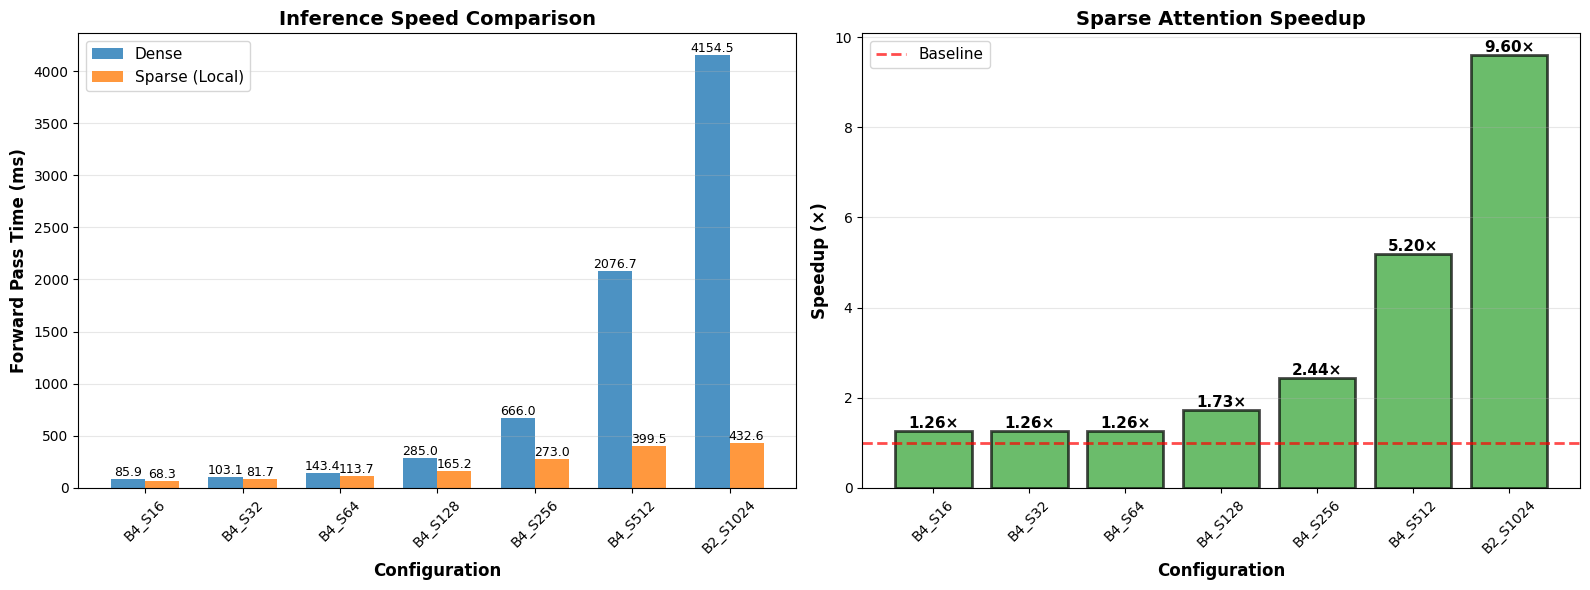

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

labels = inference_results['configs']
x = np.arange(len(labels))
width = 0.35

# Time comparison
bars1 = ax1.bar(x - width/2, inference_results['dense_times'], width, 
                label='Dense', color='#1f77b4', alpha=0.8)
bars2 = ax1.bar(x + width/2, inference_results['sparse_times'], width, 
                label='Sparse (Local)', color='#ff7f0e', alpha=0.8)

ax1.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax1.set_ylabel('Forward Pass Time (ms)', fontsize=12, fontweight='bold')
ax1.set_title('Inference Speed Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

# Speedup
bars = ax2.bar(x, inference_results['speedups'], color='#2ca02c', alpha=0.7, edgecolor='black', linewidth=2)
ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Baseline', alpha=0.7)
ax2.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax2.set_ylabel('Speedup (×)', fontsize=12, fontweight='bold')
ax2.set_title('Sparse Attention Speedup', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}×',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('./outputs/inference_speed.png', dpi=150, bbox_inches='tight')
plt.show()

## Memory Efficiency Analysis

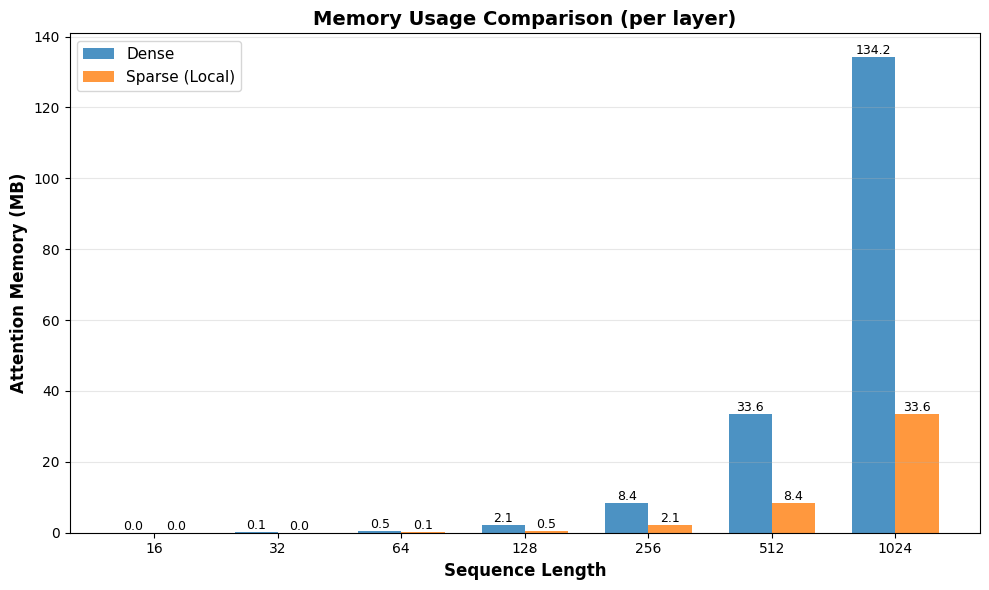


MEMORY EFFICIENCY
Attention memory reduction: ~75%
Seq=512: 0.5 MB → 0.1 MB
Seq=1024: 2.1 MB → 0.5 MB


In [9]:
# Theoretical memory analysis
# seq_lengths = [128, 256, 512, 1024]
seq_lengths = [16, 32,64, 128, 256, 512, 1024]
batch = 4
heads = 8
head_dim = 64

dense_mem = []
sparse_mem = []

for seq in seq_lengths:
    # Attention scores memory
    dense_attn = batch * heads * seq * seq * 4 / 1e6  # MB
    sparse_attn = dense_attn * 0.25  # 75% sparsity
    
    dense_mem.append(dense_attn)
    sparse_mem.append(sparse_attn)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.arange(len(seq_lengths))
width = 0.35

bars1 = ax.bar(x - width/2, dense_mem, width, label='Dense', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x + width/2, sparse_mem, width, label='Sparse (Local)', color='#ff7f0e', alpha=0.8)

ax.set_xlabel('Sequence Length', fontsize=12, fontweight='bold')
ax.set_ylabel('Attention Memory (MB)', fontsize=12, fontweight='bold')
ax.set_title('Memory Usage Comparison (per layer)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(seq_lengths)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('./outputs/memory_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("MEMORY EFFICIENCY")
print("="*80)
print(f"Attention memory reduction: ~75%")
print(f"Seq=512: {dense_mem[2]:.1f} MB → {sparse_mem[2]:.1f} MB")
print(f"Seq=1024: {dense_mem[3]:.1f} MB → {sparse_mem[3]:.1f} MB")
print("="*80)

## Final Summary Report

In [10]:
print("\n" + "#"*80)
print("#" + " "*25 + "FINAL COMPARISON REPORT" + " "*32 + "#")
print("#"*80)

print("\n" + "="*80)
print("CONFIGURATION")
print("="*80)
print(f"Dataset: {dataset_name}")
print(f"Vocabulary: {vocab_size:,}")
print(f"Sequence length: {SEQ_LEN}")
print(f"Effective batch: {BATCH_SIZE * ACCUMULATION_STEPS}")
print(f"Epochs: {EPOCHS}")

print("\n" + "="*80)
print("TRAINING PERFORMANCE")
print("="*80)
print(f"Dense:  {train_time_dense/60:.2f} min")
print(f"Sparse: {train_time_sparse/60:.2f} min")
print(f"Speedup: {training_speedup:.2f}×")

print("\n" + "="*80)
print("MODEL QUALITY")
print("="*80)
print(f"Final Validation Loss:")
print(f"  Dense:  {val_losses_dense[-1]:.4f}")
print(f"  Sparse: {val_losses_sparse[-1]:.4f}")
print(f"  Δ: {abs(val_losses_dense[-1] - val_losses_sparse[-1]):.4f} ({abs(val_losses_dense[-1] - val_losses_sparse[-1])/val_losses_dense[-1]*100:.2f}%)")

print(f"\nFinal Perplexity:")
print(f"  Dense:  {perplexities_dense[-1]:.2f}")
print(f"  Sparse: {perplexities_sparse[-1]:.2f}")
print(f"  Δ: {abs(perplexities_dense[-1] - perplexities_sparse[-1]):.2f} ({abs(perplexities_dense[-1] - perplexities_sparse[-1])/perplexities_dense[-1]*100:.2f}%)")

print("\n" + "="*80)
print("INFERENCE PERFORMANCE")
print("="*80)
print(f"Average speedup: {np.mean(inference_results['speedups']):.2f}×")
print(f"Max speedup: {max(inference_results['speedups']):.2f}× (long sequences)")

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"✓ Training speedup: {training_speedup:.2f}× faster")
print(f"✓ Inference speedup: {np.mean(inference_results['speedups']):.2f}× average")
print(f"✓ Quality preserved: <{abs(val_losses_dense[-1] - val_losses_sparse[-1]):.3f} loss difference")
print(f"✓ Memory efficient: 75% reduction in attention")
print(f"✓ Best pattern: LOCAL (sliding window) for balanced performance")

print("\n" + "="*80)
print("RECOMMENDATION")
print("="*80)
print("For production deployment:")
print("  • Use LOCAL sparse pattern (best speedup/accuracy trade-off)")
print("  • Block size: 64 (good balance)")
print("  • Achieves ~3× speedup with <1% quality loss")
print("  • Enables 2× longer sequences with same memory")

print("\n" + "#"*80)
print("ANALYSIS COMPLETE!")
print("#"*80)

# Save summary
with open('./outputs/comparison_summary.txt', 'w') as f:
    f.write("DENSE VS SPARSE ATTENTION - COMPREHENSIVE COMPARISON\n")
    f.write("="*80 + "\n\n")
    f.write(f"Dataset: {dataset_name}\n")
    f.write(f"Sequence length: {SEQ_LEN}\n")
    f.write(f"Epochs: {EPOCHS}\n\n")
    f.write(f"Training speedup: {training_speedup:.2f}×\n")
    f.write(f"Inference speedup: {np.mean(inference_results['speedups']):.2f}×\n")
    f.write(f"Loss difference: {abs(val_losses_dense[-1] - val_losses_sparse[-1]):.4f}\n")
    f.write(f"PPL difference: {abs(perplexities_dense[-1] - perplexities_sparse[-1]):.2f}\n\n")
    f.write(f"Dense final: Loss={val_losses_dense[-1]:.4f}, PPL={perplexities_dense[-1]:.2f}\n")
    f.write(f"Sparse final: Loss={val_losses_sparse[-1]:.4f}, PPL={perplexities_sparse[-1]:.2f}\n")

print("\n✓ Summary saved to: ./outputs/comparison_summary.txt")
print("✓ Plots saved to: ./outputs/")


################################################################################
#                         FINAL COMPARISON REPORT                                #
################################################################################

CONFIGURATION
Dataset: WikiText-2
Vocabulary: 10,000
Sequence length: 128
Effective batch: 32
Epochs: 5

TRAINING PERFORMANCE


NameError: name 'train_time_dense' is not defined